<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

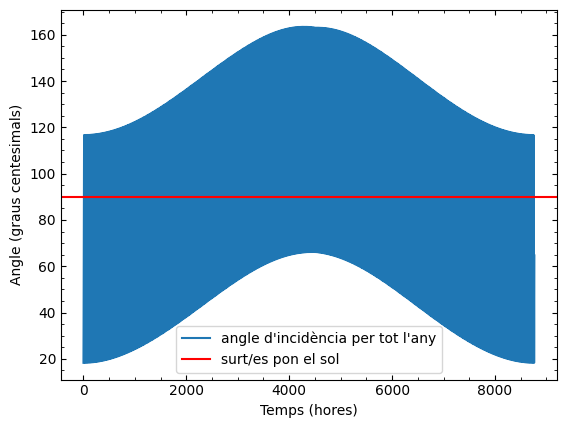

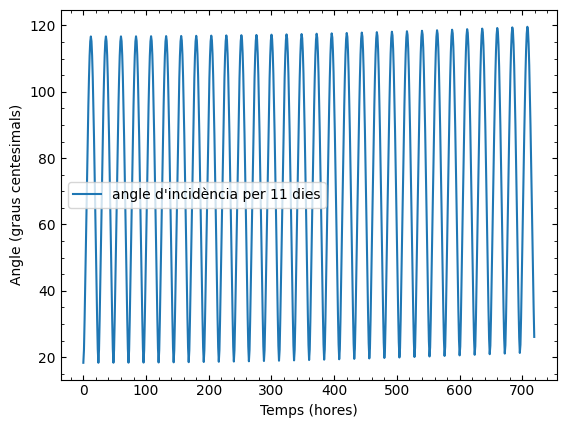

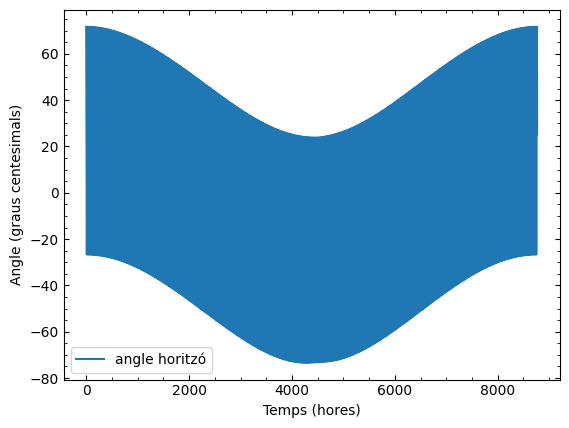

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos):
  pos = cos[:3]*(1/r0)*10**3
  vel = cos[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
posicions= np.array([pos_sol, pos_terra, pos_lluna])
velocitats= np.array([vel_sol, vel_terra, vel_lluna])

def acceleracions(pos, masses): # pos és una matriu de N files i 3 columnes
    N= len(masses) # Nombre de cossos: planetes, el Sol i la Lluna
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

t_f = 365
dt = 1/24
hores= int(t_f/dt)
passos = hores +6  #per tenir en compte que un any dura 365 dies i 6 hores afegim 5 + CI = 6 hores "extres" als 365 dies calculats
#AIXÒ ENS DONA L'HORA JUST ABANS DE RETORNAR A LES CONDICIONS INICIALS. SI VOLEM TROBAR EL MOMENT DEL QUE HEM PARTIT PERO UN ANY DESPRÉS HEM DE POSAR EL TEMPS SEGÜENT ÉS A DIR UN + 6

pos_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos):
  pos_nou, vel_nou = rk4(pos_hist[i], vel_hist[i], masses, dt)
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

# Volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/23.9344444 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

x = np.array([0])
y = np.array([R_t*np.cos(phi-theta)])
z = np.array([R_t*np.sin(phi-theta)])

t = np.linspace(1,passos-1,passos)

# Aquestes són les coordenades del vector centre terra-bellaterra durant el temps que considerem més condicions inicials
X_b = np.concatenate((x, (-1)*R_t * np.cos(phi)*np.sin(vel_ang*t)))
Y_b = np.concatenate((y, (np.cos(phi-theta)*np.cos(vel_ang*t) + np.sin(theta)*(1-np.cos(vel_ang*t))*np.sin(phi)) * R_t))
Z_b = np.concatenate((z, (np.sin(phi-theta)*np.cos(vel_ang*t) + np.cos(theta)*(1-np.cos(vel_ang*t))*np.sin(phi)) * R_t))

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)


modul_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
modul_b = np.sqrt(X_b**2 + Y_b**2 + Z_b**2)


cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(modul_b * modul_t)
cos_llista = np.clip(cos_llista, -1.0, 1.0)  # Per evitar problemes numèrics degut a que farem servir la funció arcosinus


temps = np.linspace(0,passos,passos+1)

theta_llista = np.pi - np.arccos(cos_llista) #obtenim l'angle complementari que és el que ens interessa.


plt.plot(temps,theta_llista*365/(2*np.pi), label ="angle d'incidència per tot l'any")
plt.ylabel("Angle (graus centesimals)")
plt.xlabel("Temps (hores)")
plt.axhline(90, color="r", label = "surt/es pon el sol")
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.minorticks_on()
plt.legend()
plt.show()

plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi), label="angle d'incidència per 11 dies") #això són els primers 11 dies pq es vegi més bé les oscil·lacions
plt.ylabel("Angle (graus centesimals)")
plt.xlabel("Temps (hores)")
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.minorticks_on()
plt.legend()
plt.show()
horitzo = 90-(theta_llista)*365/(2*np.pi)

plt.plot(temps,horitzo, label = "angle horitzó") #els angles negatius corresponenen a la nit, llavors no podem calcular un angle d'elevació del sol.
plt.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
plt.ylabel("Angle (graus centesimals)")
plt.xlabel("Temps (hores)")
plt.minorticks_on()
plt.legend()
plt.show()




In [ ]:
theta_llista_g = theta_llista *  360/ (2 * np.pi) #canviem a graus centesimals
creuament = 0
#trobem quants cops passem del llindar de 90 graus i es fa de nit o de dia.
for i in range(len(theta_llista_g) - 1):
    if (theta_llista_g[i] < 90 and theta_llista_g[i+1] > 90) or (theta_llista_g[i] > 90 and theta_llista_g[i+1] < 90):
        creuament += 1

print(f"Es creua la línia blava (dia-nit o bé nit-dia) {creuament} cops. Per tant, han passat {creuament/2} dies, que correspon a 1 any.")

Es creua la línia blava (dia-nit o bé nit-dia) 730 cops. Per tant, han passat 365.0 dies, que correspon a 1 any.


In [ ]:
index=[]
#trobem quin és l'index del primer valor d'angle d'inclinació de cada dia
for i in range(len(horitzo) - 1):
    if horitzo[i] < 0 and horitzo[i+1] >= 0:
        index.append(i+1)
print(index)

[17, 41, 65, 89, 113, 137, 161, 185, 209, 233, 257, 281, 305, 329, 353, 377, 401, 425, 449, 473, 497, 521, 545, 569, 593, 617, 641, 665, 689, 714, 738, 762, 786, 810, 834, 858, 882, 906, 930, 954, 978, 1002, 1026, 1050, 1074, 1098, 1122, 1146, 1170, 1194, 1218, 1242, 1266, 1290, 1314, 1338, 1362, 1386, 1410, 1434, 1458, 1482, 1506, 1530, 1554, 1578, 1602, 1626, 1650, 1674, 1698, 1722, 1746, 1770, 1794, 1818, 1842, 1866, 1890, 1914, 1938, 1962, 1987, 2011, 2035, 2059, 2083, 2107, 2131, 2155, 2179, 2203, 2227, 2251, 2275, 2299, 2323, 2347, 2371, 2395, 2419, 2443, 2467, 2491, 2515, 2539, 2563, 2587, 2611, 2635, 2659, 2683, 2707, 2731, 2755, 2779, 2803, 2827, 2851, 2875, 2899, 2923, 2947, 2971, 2995, 3019, 3043, 3067, 3091, 3115, 3140, 3164, 3188, 3212, 3236, 3260, 3284, 3308, 3332, 3356, 3380, 3404, 3428, 3452, 3476, 3500, 3524, 3548, 3572, 3596, 3620, 3644, 3668, 3692, 3716, 3740, 3764, 3788, 3812, 3836, 3860, 3884, 3908, 3932, 3956, 3980, 4004, 4028, 4052, 4076, 4100, 4124, 4148, 4172, 

365


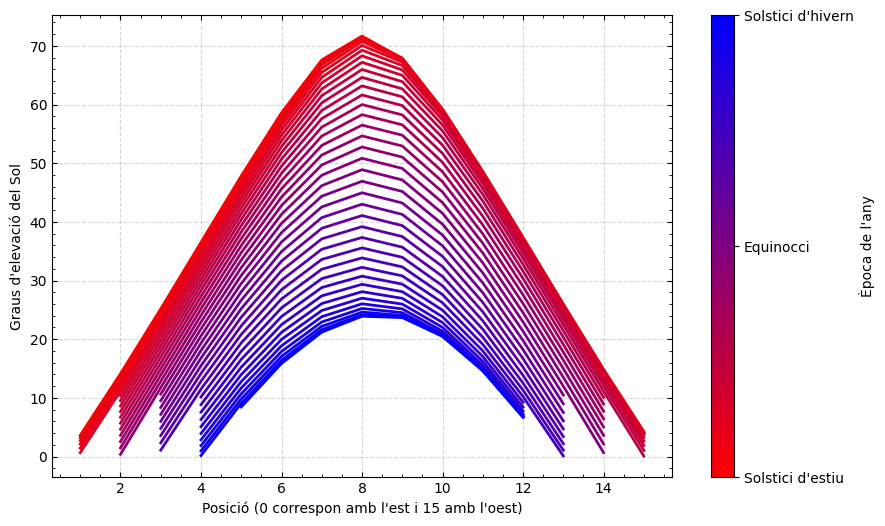

l'elevació mínima és 23.91637663678192 graus centesimals
l'elevació màxima és 71.66815165177735 graus centesimals


In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

Colors = ["red", "purple", "blue"]
mapa = LinearSegmentedColormap.from_list("seasonal_temp_cmap", Colors, N=256)
temps_norm = plt.Normalize(vmin=0, vmax=len(temps) * 0.5)

fig1, ax1 = plt.subplots(figsize=(10,6))
valors_cum=[]
print(len(index))

#ara dibuixarem l'angle d'elevació del sol vist de Bellaterra durant mig any cada 5 dies.
for i in range(37):
  valors=[]
  j=0
  index_segment = index[5*i]
  color_segment = mapa(temps_norm(index_segment))

  while True:

    if horitzo[index[5*i]+j] < 0:

      break

    valors.append(horitzo[index[5*i]+j])
    j = j + 1
  valors_cum.append(valors)
  if valors:

    max_index = np.argmax(valors)
    inici_desplaçat = 8 - max_index
    x = np.linspace(inici_desplaçat, inici_desplaçat + len(valors) - 1, len(valors))
    ax1.plot(x, valors, color=color_segment, linewidth=2)


ax1.set_xlabel("Posició (0 correspon amb l'est i 15 amb l'oest)")
ax1.set_ylabel("Graus d'elevació del Sol")
ax1.tick_params(axis="both", which = "both", direction ="in", top=True, right=True)
ax1.minorticks_on()


sm = ScalarMappable(cmap=mapa, norm=temps_norm)
sm.set_array([])
barra = fig1.colorbar(sm, ax=ax1)
barra.set_label("Època de l'any")


hores_t = len(temps) - 1
barra.set_ticks([0, hores_t * 0.25, hores_t * 0.5])
barra.set_ticklabels(["Solstici d'estiu", "Equinocci", "Solstici d'hivern"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#trobar els valors minim i maxim
maxims = []
for i in valors_cum:
  maxims.append(max(i))

print("l'elevació mínima és", min(maxims),"graus centesimals")
print("l'elevació màxima és", max(maxims),"graus centesimals")